# Experiment Setup

## Audio Corpus
We will be using an episode from a runway incident for our multi-speaker diarization experiments. The aim of this transcription and subsequent air incident investigation report is to test the `medium` Whisper model on the quality of audio used by ATC, `pyannote`'s diarization model, and `GPT 4o`'s air incident investigation report generation capabilities.

We will be testing it on a sample episode that features a conversation between multiple speakers on frequency. The exact lexicon used in the conversation recording includes ATC phrases. We will be testing the model's ability to transcribe these phrases accurately. The video provides:
- One WAV file containing the overall audio.

Context of incident 
> A Southwest aircraft performing flight SWA3828/WN3828 from Chicago-Midway KMDW to Tulsa KTUL, and a Delta aircraft performing flight 
DAL1328/DL1328 from Chicago-Midway to Atlanta KATL had a very close call when both aircraft started to roll at once.
>
> Similar callsigns caused the Delta pilots to misunderstand the Southwest takeoff clearance. They both were instantly given a STOP STOP call.


## Model
We will be using the `medium` model offered by OpenAI to perform transcription.

We will be using the `pyannote/speaker-diarization-3.1` model offered by Pyannote to perform diarization.

We will be using the `GPT4o` model offered by OpenAI to generate the Air Incident Investigation Report.



In [1]:
!pip install openai python-dotenv faster-whisper

In [2]:
import threading
import time
import dotenv
from openai import AzureOpenAI

DEPLOYMENT = dotenv.get_key(dotenv.find_dotenv(), "DEPLOYMENT")
ENDPOINT = dotenv.get_key(dotenv.find_dotenv(), "AZURE_OPENAI_ENDPOINT")
KEY = dotenv.get_key(dotenv.find_dotenv(), "AZURE_OPENAI_KEY")
VERSION = dotenv.get_key(dotenv.find_dotenv(), "AZURE_OPENAI_VERSION")
HF_ACCESS_KEY = dotenv.get_key(dotenv.find_dotenv(),"HF_ACCESS_KEY")
# gets the API Key from environment variable AZURE_OPENAI_API_KEY
client = AzureOpenAI(
	# https://learn.microsoft.com/en-us/azure/ai-services/openai/reference#rest-api-versioning
	api_version=VERSION,
	# https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal#create-a-resource
	azure_endpoint=ENDPOINT,
	api_key=KEY

)

Python-dotenv could not parse statement starting at line 1
Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 1
Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 1
Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 1
Python-dotenv could not parse statement starting at line 2
Python-dotenv could not parse statement starting at line 3
Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line

In [3]:
import whisper
import torch
torch.cuda.init()

model = whisper.load_model("medium")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1024, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0-23): 24 x ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (key): Linear(in_features=1024, out_features=1024, bias=False)
          (value): Linear(in_features=1024, out_features=1024, bias=True)
          (out): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (attn_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
        (mlp_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_post): LayerNorm((

# Meeting-Specific Prompts and Phrases


In [3]:
general = ['Air Traffic Control communications','1','2','3','4','5','6','7','8','9','0','90','180','270','360']
nato = [
	'Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo', 'Foxtrot', 'Golf',
	'Hotel', 'India', 'Juliett', 'Kilo', 'Lima', 'Mike', 'November',
	'Oscar', 'Papa', 'Quebec', 'Romeo', 'Sierra', 'Tango', 'Uniform',
	'Victor', 'Whiskey', 'Xray', 'Yankee', 'Zulu'
]

atc_words = [
    "acknowledge", "affirmative","affirm", "altitude", "approach", "apron", "arrival",
    "bandbox", "base", "bearing", "cleared", "climb", "contact", "control",
    "crosswind", "cruise", "descend", "departure", "direct", "disregard",
    "downwind", "estimate", "final", "flight", "frequency", "go around",
    "heading", "hold", "identified", "immediate", "information", "instruct",
    "intentions", "land", "level", "maintain", "mayday", "message", "missed",
    "navigation", "negative", "obstruction", "option", "orbit", "pan-pan",
    "pattern", "position", "proceed", "radar", "readback", "received",
    "report", "request", "required", "runway", "squawk", "standby", "takeoff",
    "taxi", "threshold", "traffic", "transit", "turn", "vector", "visual",
    "waypoint", "weather", "wilco", "wind", "with you", "speed",
    "heavy", "light", "medium", "emergency", "fuel", "identifier",
    "limit", "monitor", "notice", "operation", "permission", "relief",
    "route", "signal", "stand", "system", "terminal", "test", "track",
    "understand", "verify", "vertical", "warning", "zone", "no", "yes", "unable",
    "clearance", "conflict", "coordination", "cumulonimbus", "deviation", "enroute",
    "fix", "glideslope", "handoff", "holding", "IFR", "jetstream", "knots",
    "localizer", "METAR", "NOTAM", "overfly", "pilot", "QNH", "radial",
    "sector", "SID", "STAR", "tailwind", "transition", "turbulence", "uncontrolled",
    "VFR", "wake turbulence", "X-wind", "yaw", "Zulu time", "airspace",
    "briefing", "checkpoint", "elevation", "FL",
    "ground control", "hazard", "ILS", "jetway", "kilo", "logbook", "missed approach",
    "nautical mile", "offset", "profile", "quadrant", "RVR",
    "static", "touchdown", "upwind", "variable", "wingtip", "Yankee", "zoom climb",
    "airspeed", "backtrack", "ETOPS", "gate", "holding pattern", 
    "jumpseat", "minimums", "pushback", "RNAV", "slot time", "taxiway", "TCAS",
    "wind shear", "zero fuel weight", "ETA",
    "flight deck", "ground proximity warning system", "jet route",
    "landing clearance", "Mach number", "NDB", "obstacle clearance",
    "PAPI", "QFE", "radar contact",
    'ATC', 'pilot', 'call sign', 'altitude', 'heading', 'speed', 'climb to', 'descend to',
    'maintain', 'tower', 'ground', 'runway', 'taxi', 'takeoff', 'landing',
    'flight level', 'traffic', 'hold short', 'cleared for',
    'roger', 'visibility', 'weather', 'wind', 'gusts',
    'icing conditions', 'deicing', 'VFR', 'IFR', 'no-fly zone',
    'restricted airspace', 'flight path', 'direct route', 'vector', 'frequency change',
    'final approach', 'initial climb to', 'contact approach', 'FIR', 'control zone', 'TMA',
    'missed approach', 'minimum safe altitude', 'transponder',
    'reduce speed to', 'increase speed to',
    'flight conditions', 'clear of conflict', 'resume own navigation', 'request altitude change',
    'request route change', 'flight visibility', 'ceiling', 'severe weather', 'convective SIGMET',
    'AIRMET', 'QNH', 'QFE', 'transition altitude', 'transition level',
    'NOSIG', 'TFR', 'special use airspace',
    'MOA', 'IAP', 'visual approach',
    'NDB', 'VOR',
    'ATIS', 'engine start clearance',
    'line up and wait', 'unicom', 'cross runway', 'departure frequency',
    'arrival frequency', 'go-ahead', 'hold position', 'check gear down',
    'touch and go', 'circuit pattern', 'climb via SID',
    'descend via STAR', 'speed restriction', 'flight following', 'radar service terminated', 'squawk VFR',
    'change to advisory frequency', 'report passing altitude', 'report position',
    'ATD', 'block altitude', 'cruise climb', 'direct to', 'execute missed approach',
    'in-flight refueling', 'joining instructions', 'lost communications', 'MEA', 'next waypoint', 'OCH',
    'procedure turn', 'radar vectoring', 'radio failure', 'short final', 'standard rate turn',
    'TRSA', 'undershoot', 'VMC',
    'wide-body aircraft', 'yaw damper', 'zulu time conversion', 'RNAV',
    'RNP', 'barometric pressure', 'control tower handover', 'datalink communication',
    'ELT', 'FDR', 'GCI',
    'hydraulic failure', 'IMC', 'knock-it-off',
    'LVO', 'MAP', 'NAVAIDS',
    'oxygen mask deployment', 'PAR', 'QRA',
    'runway incursion', 'SAR', 'tail strike', 'upwind leg', 'vertical speed',
    'wake turbulence category', 'X-ray cockpit security', 'yield to incoming aircraft', 'zero visibility takeoff','good day', 'no delay'

]


collated_list = general + nato + atc_words 




collated_list_string = ' '.join(collated_list)

# Our Experiment
## Label-Aware Strided Adaptive Diarization

In this experiment, we implement a strategy to update chunks with strides, incorporating both past and future context, and enhancing the diarization process by making the model aware of speaker labels from previous chunks.

### Methodology

We split the transcribed text into `x` number of chunks, and for each chunk, we also add a stride of `a` behind and in front of the chunk. This approach allows us to capture the conversation context more effectively and thus provide a more accurate diarization.

#### Chunking and Stride

1. **Chunk Size and Number of Chunks:**

\begin{equation}
N = \text{length of list}
\end{equation}

\begin{equation}
c = \text{chunk size}, \, a = \text{stride length}
\end{equation}

\begin{equation}
x = \left\lceil \frac{N}{c} \right\rceil, \, \text{number of chunks}
\end{equation}

2. **Initial Chunk Definition:**

\begin{equation}
S_i = i \cdot c, \, E_i = \min((i+1) \cdot c - 1, N-1), \, 0 \leq i < x
\end{equation}

3. **Stride Modifications:**

\begin{equation}
\text{For } i = 1 \text{ to } x-2:
\end{equation}

\begin{equation}
\text{Prepend } \text{sort}(\text{last } a \text{ elements of } \text{chunk}_{i-1}, \text{desc}) \text{ to } \text{chunk}_i
\end{equation}

\begin{equation}
\text{Append } \text{sort}(\text{first } a \text{ elements of } \text{chunk}_{i+1}) \text{ to } \text{chunk}_i
\end{equation}

\begin{equation}
\text{For } i = 0 \text{ and } i = x-1, \text{ chunks remain unchanged.}
\end{equation}

### Example

Consider the initial chunked list and its updated version with a stride \(a=2\):

#### Initial chunked list:

\begin{bmatrix}
[0, 1, 2, 3, 4, 5] \\
[6, 7, 8, 9, 10, 11] \\
[12, 13, 14, 15, 16, 17] \\
[18, 19, 20, 21]
\end{bmatrix}


#### Updated with stride:

\begin{bmatrix}
[0, 1, 2, 3, 4, 5] \\
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13] \\
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19] \\
[16, 17, 18, 19, 20, 21]
\end{bmatrix}



### Diarization Process

Each chunk, upon submission, will carry the respective speaker labels for the preceding \(a\) elements, enriching the context for improved accuracy.

**Backstride:** Elements from the past stride

**Forwardstride:** Elements from the future stride

Starting with chunk 1 (where 0 ≤ i < x), specifically the second chunk:


\begin{bmatrix}
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
\end{bmatrix}


The last \(a=2\) speaker labels from the `backstride` will be incorporated into the context. 

If, for instance, the speaker labels for elements \(4\) and \(5\) are `Speaker 1`, this provides the Language Model (LLM) with valuable historical context from the previous diarization session, hypothetically enabling more precise diarization results.

### Final Formulation

#### Initial Chunks:

\begin{equation}
\text{chunks}_i = [i \cdot c \text{ to } (i+1) \cdot c - 1]
\end{equation}

#### Stride Modifications:

\begin{equation}
\text{chunks}_i = [(\text{chunks}_{i-1} \text{ last } a \text{ elements}) + \text{chunks}_i + (\text{chunks}_{i+1} \text{ first } a \text{ elements})]
\end{equation}

#### Label-Aware Diarization:

\begin{equation}
\text{Speaker Labels for chunk}_i = \text{LLM}( \text{chunks}_i \text{ with context from previous labels} )
\end{equation}

This approach enriches the information available for each chunk, aiding the Language Model in generating more accurate diarization outcomes by leveraging historical speaker labels.


In [4]:
import os
import re
import ast
from datetime import datetime
import pandas as pd
import numpy as np
import json
from collections import deque

In [5]:
# Setup code
# Specify the directory path
transcriptions_dir = "./transcriptions"
audio_file = '../content/atc/atc_incident.wav'
specific_filename = "atc_incident.json"

In [6]:
import os
import json
from datetime import datetime

# Check if the directory exists
if not os.path.exists(transcriptions_dir):
    # If the directory does not exist, create it
    os.makedirs(transcriptions_dir)

def find_latest_transcription(directory, specific_filename):
    for filename in os.listdir(directory):
        if filename == specific_filename:
            return filename
    return None

# Attempt to find the specific transcription file
latest_transcription_file = find_latest_transcription(transcriptions_dir, specific_filename)

if latest_transcription_file:
    # Full path for the latest file including the directory
    file_path = os.path.join(transcriptions_dir, latest_transcription_file)
    # Extract the filename without the extension
    file_name, _ = os.path.splitext(latest_transcription_file)
    try:
        with open(file_path, "r") as stored_result:
            # If the file exists and is opened successfully, read the content
            result = json.load(stored_result)
        print('\033[92mTranscription located:\033[0m')
        # Extract and print the first 5 sentences
        segments = result.get('segments', [])
        for segment in segments[:5]:
            start_time = round(float(segment['start']),2)
            end_time = round(float(segment['end']),2)
            text = segment['text']
            print(f'[{start_time}:{end_time}] -> {text}')
        print('...')

    except FileNotFoundError:
        print("File not found, although it was expected to exist.")
else:
    # No transcription file matching the pattern was found
    print('\033[91mNo matching transcription files found.\033[0m')
    # If the file does not exist, execute the transcription process and create the file
    temp_result = model.transcribe(audio_file, verbose=True, language="en", prompt=collated_list_string)
    file_path = os.path.join(transcriptions_dir, specific_filename)
    with open(file_path, "w") as f:
        json.dump(temp_result, f)
    result = temp_result
    # Extract the filename without the extension
    file_name, _ = os.path.splitext(os.path.basename(file_path))
    print(f'\033[92mTranscription completed and saved at {file_path}.\033[0m')

per_line = []
for segment in result['segments']:
    text_to_append = segment['text']
    text_to_append = text_to_append[1:]
    per_line.append(text_to_append)


Transcription located:
[0.0:17.56] ->  Delta 1328, be advised similar call sign on frequency of Southwest 3828, cross Runway
[17.56:21.84] ->  31 Center and Runway 31 left, taxi via Yankee to 4 right.
[22.08:27.12] ->  To clear to cross 31 Center and 31 left, Yankee to 4 right, Delta 1328, we'll be aware.
[28.0:36.28] ->  Southwest 3828, be advised similar call sign on frequency of Delta 1328 and once you approach
[36.28:39.6] ->  31 right as you're crossing it you can switch over to power, have a good day.
...


In [7]:
len(per_line)

43

In [8]:
# Initialization code for strided_chunks and strided_chunk_indices
STRIDE = 2
TOTAL_NUMBER_OF_LINES = len(per_line)
DESIRED_CHUNK_SIZE = 4

def calculate_number_of_chunks_with_stride(total_lines, chunk_size, stride):
    effective_chunk_size = chunk_size + stride - 1  # Adjust chunk size to account for stride
    number_of_chunks = (total_lines + effective_chunk_size - 1) // effective_chunk_size
    return number_of_chunks

def find_optimal_chunks(total_lines, desired_chunk_size, max_stride):
    # Iterate through stride values from max_stride down to 1
    for stride in range(max_stride, 0, -1):
        number_of_chunks = calculate_number_of_chunks_with_stride(total_lines, desired_chunk_size, stride)
        # Check if the total coverage with the current number of chunks and chunk size is sufficient
        if number_of_chunks * desired_chunk_size >= total_lines:
            return number_of_chunks, stride
    return -1, -1  # Return an error if no suitable chunk and stride combination is found

NUMBER_OF_CHUNKS, STRIDE = find_optimal_chunks(TOTAL_NUMBER_OF_LINES, DESIRED_CHUNK_SIZE, STRIDE)
print('Optimal Number of Chunks:', NUMBER_OF_CHUNKS)
print('Optimal Stride:',STRIDE)
# but i prefer for stride to be 2 as it retains more history so...
STRIDE = 2
print('Forced Stride:', 2)

Optimal Number of Chunks: 11
Optimal Stride: 1
Forced Stride: 2


In [10]:
def chunk_with_stride_and_indices(initial_list: list, stride: int, number_of_chunks: int):
    stride -= 1
    N = len(initial_list)

    # Calculate base chunk size without considering stride for simplicity
    base_chunk_size = (N + number_of_chunks - 1) // number_of_chunks

    # Prepare initial chunks without stride
    initial_chunks = [initial_list[i * base_chunk_size:(i + 1) * base_chunk_size] for i in range(number_of_chunks)]
    initial_chunk_indices = [list(range(i * base_chunk_size, min((i + 1) * base_chunk_size, N))) for i in range(number_of_chunks)]

    stride_chunks = []
    stride_chunk_indices = []

    for i in range(number_of_chunks):
        # Calculate the effective start and end, incorporating stride where applicable
        start = max(0, i * base_chunk_size - stride)
        end = min(N, (i + 1) * base_chunk_size + stride if i < number_of_chunks - 1 else N)

        # Slice the original list and indices accordingly
        current_chunk = initial_list[start:end]
        current_indices = list(range(start, end))

        stride_chunks.append(current_chunk)
        stride_chunk_indices.append(current_indices)

    return stride_chunks, stride_chunk_indices

strided_chunks, strided_chunk_indices = chunk_with_stride_and_indices(per_line, STRIDE, NUMBER_OF_CHUNKS)

# Remove empty lists
strided_chunk_indices = [ele for ele in strided_chunk_indices if ele != []]
strided_chunks = [ele for ele in strided_chunks if ele != []]

# Assuming 'per_line' and 'strided_chunk_indices' are defined elsewhere in the script
comparison_df = pd.DataFrame({'original': per_line})

# Use numpy to efficiently calculate the min and max values for DataFrame index
min_val = np.min([min(sublist) for sublist in strided_chunk_indices])
max_val = np.max([max(sublist) for sublist in strided_chunk_indices])

# Initialize the DataFrame with the correct index range
strided_chunk_df = pd.DataFrame(index=np.arange(min_val, max_val + 1))

# Populate the DataFrame with strided chunk data
for i, sublist in enumerate(strided_chunk_indices):
    # Direct assignment to the DataFrame using loc for precise index matching
    strided_chunk_df.loc[sublist, f'strided_chunk_{i}'] = strided_chunks[i]

# Combine the initial comparison DataFrame with the newly created strided chunk DataFrame
combined_df = pd.concat([comparison_df, strided_chunk_df], axis=1)

class TextDiarizer:
    def __init__(self, client, deployment):
        self.client = client
        self.deployment = deployment

    def diarize_chunk(self, sentences, prev_labels_info=None):
        """Diarize a chunk of text, optionally using information from previous labels."""
        system_message = "You are a linguistics expert with 100 years of experience. You will be given a transcription of a meeting between 4 people, and you are to assign the Speaker label to each sentence PER line. I.e. Given the prompt, you will return me: ['Speaker 1', 'Speaker 2', 'Speaker 2']. There is a possibility that a speaker may speak for more than 1 line at time. You will DO YOUR JOB WELL."

        if prev_labels_info:
            prev_speaker_labels = list(prev_labels_info.values())
            sentences_dict = prev_speaker_labels[0]
            speaker_labels_dict = prev_speaker_labels[1]

            # creating {'sentence':speaker_label} dictionary
            sentence_speaker_mapping = {value: speaker_labels_dict[key] for key, value in sentences_dict.items()}

            user_message = f"Here are the previous exchanges RIGHT before this followed by their respective speaker(s):\n{sentence_speaker_mapping} \n Here is the list of sentences:\n{sentences}\nNote that this contains the previous exchanges as well. I MUST RECEIVE ALL {len(sentences)} exchanges. JUST RETURN ME THE LIST."
        else:
            user_message = f"Here is the list of sentences: \n{sentences}. \nThere are {len(sentences)} exchanges. You will diarize ALL the sentences in the list. You WILL ensure that you label ALL {len(sentences)} lines. JUST RETURN ME THE LIST."
        print('user message:', user_message + '\n\n')
        diarization = self.client.chat.completions.create(
            model=self.deployment,
            messages=[
                {"role": "system", "content": system_message},
                {"role": "user", "content": user_message}
            ],
            max_tokens=2500,
            stream=False,
            temperature=0.2,
        )
        return ast.literal_eval(diarization.choices[0].message.content)

    def get_stride_info(self, chunk_df, total_label_list, chunk_number, stride):
        """Retrieve and label the information for a given stride."""
        column_name = f'strided_chunk_{chunk_number}'
        chunk_df[column_name] = chunk_df[column_name].replace('nan', np.nan)

        _ = chunk_df[column_name].dropna()
        stride_df = pd.DataFrame(_.tail(stride))
        previous_speaker_labels = total_label_list[-1][-stride:]
        stride_df['speaker_labels'] = previous_speaker_labels
        return stride_df.to_dict()

    def label_aware(self, stride, number_of_chunks, combined_chunk_df):
        total_label_list = []

        # Process the first chunk
        combined_chunk_df['strided_chunk_0'] = combined_chunk_df['strided_chunk_0'].replace('nan', np.nan)
        first_chunk = combined_chunk_df['strided_chunk_0'].dropna().tolist()
        speaker_labels = self.diarize_chunk(first_chunk)
        total_label_list.append(speaker_labels)

        # Process subsequent chunks
        for chunk_number in range(1, (len(combined_chunk_df.columns) - 1)):
            column_name = f'strided_chunk_{chunk_number}'
            combined_chunk_df[column_name] = combined_chunk_df[column_name].replace('nan', np.nan)
            current_chunk = combined_chunk_df[column_name].dropna(how='any').tolist()
            prev_labels_info = self.get_stride_info(combined_chunk_df, total_label_list, chunk_number - 1, stride)
            speaker_labels = self.diarize_chunk(current_chunk, prev_labels_info)
            total_label_list.append(speaker_labels)

        return total_label_list

diarizer = TextDiarizer(client, DEPLOYMENT)
final_labels = diarizer.label_aware(STRIDE, NUMBER_OF_CHUNKS, combined_df)
print(final_labels)

def final_df(per_line, strided_chunk_indices, final_labels):
    # Assuming 'per_line' and 'strided_chunk_indices' are defined elsewhere in the script
    label_comparison_df = pd.DataFrame({'original': per_line})

    # Use numpy to efficiently calculate the min and max values for DataFrame index
    min_val = np.min([min(sublist) for sublist in strided_chunk_indices])
    max_val = np.max([max(sublist) for sublist in strided_chunk_indices])

    # Initialize the DataFrame with the correct index range
    label_strided_chunk_df = pd.DataFrame(index=np.arange(min_val, max_val + 1))

    # Populate the DataFrame with strided chunk data
    for i, sublist in enumerate(strided_chunk_indices):
        # Direct assignment to the DataFrame using loc for precise index matching
        label_strided_chunk_df.loc[sublist, f'strided_chunk_{i}'] = final_labels[i]

    # Combine the initial comparison DataFrame with the newly created strided chunk DataFrame
    combined_label_df = pd.concat([label_comparison_df, label_strided_chunk_df], axis=1)
    return combined_label_df

final_label_df = final_df(per_line, strided_chunk_indices, final_labels)
final_label_df


user message: Here is the list of sentences: 
['Delta 1328, be advised similar call sign on frequency of Southwest 3828, cross Runway', '31 Center and Runway 31 left, taxi via Yankee to 4 right.', "To clear to cross 31 Center and 31 left, Yankee to 4 right, Delta 1328, we'll be aware.", 'Southwest 3828, be advised similar call sign on frequency of Delta 1328 and once you approach', "31 right as you're crossing it you can switch over to power, have a good day."]. 
There are 5 exchanges. You will diarize ALL the sentences in the list. You WILL ensure that you label ALL 5 lines. JUST RETURN ME THE LIST.

user message: Here are the previous exchanges RIGHT before this followed by their respective speaker(s):
{'Southwest 3828, be advised similar call sign on frequency of Delta 1328 and once you approach': 'Speaker 1', "31 right as you're crossing it you can switch over to power, have a good day.": 'Speaker 1'} 
 Here is the list of sentences:
['Southwest 3828, be advised similar call sign o

,original,strided_chunk_0,strided_chunk_1,strided_chunk_2,strided_chunk_3,strided_chunk_4,strided_chunk_5,strided_chunk_6,strided_chunk_7,strided_chunk_8,strided_chunk_9,strided_chunk_10
0,"Delta 1328, be advised similar call sign on fr...",Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,"31 Center and Runway 31 left, taxi via Yankee ...",Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,"To clear to cross 31 Center and 31 left, Yanke...",Speaker 2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,"Southwest 3828, be advised similar call sign o...",Speaker 1,Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,31 right as you're crossing it you can switch ...,Speaker 1,Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,Alright we'll be listening up for that and we'...,nan,Speaker 2,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,"Delta 1328, Midway tower, traffic hold positio...",nan,Speaker 3,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,"final, land in parallel, and traffic you're on...",nan,Speaker 3,Speaker 3,nan,nan,nan,nan,nan,nan,nan,nan
8,"Alright Delta 1328, Delta 1328 Midway tower, r...",nan,Speaker 3,Speaker 3,nan,nan,nan,nan,nan,nan,nan,nan
9,"Delta 1328, line up right, Southwest 3828.",nan,nan,Speaker 4,nan,nan,nan,nan,nan,nan,nan,nan


### Storing Results

In [9]:
import os
import pandas as pd

DF_FILE_NAME = './final_labels/' + file_name + '.h5'


if os.path.exists(DF_FILE_NAME):
    store = pd.HDFStore(DF_FILE_NAME)
    store_label_df = store['df']
    store.close()
else:
    store_label_df = final_label_df.copy()
    store = pd.HDFStore(DF_FILE_NAME)
    store['df'] = store_label_df  # save it
    store.close()

store_label_df

,original,strided_chunk_0,strided_chunk_1,strided_chunk_2,strided_chunk_3,strided_chunk_4,strided_chunk_5,strided_chunk_6,strided_chunk_7,strided_chunk_8,strided_chunk_9,strided_chunk_10
0,"Delta 1328, be advised similar call sign on fr...",Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,"31 Center and Runway 31 left, taxi via Yankee ...",Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,"To clear to cross 31 Center and 31 left, Yanke...",Speaker 2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,"Southwest 3828, be advised similar call sign o...",Speaker 1,Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,31 right as you're crossing it you can switch ...,Speaker 1,Speaker 1,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,Alright we'll be listening up for that and we'...,nan,Speaker 2,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,"Delta 1328, Midway tower, traffic hold positio...",nan,Speaker 3,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,"final, land in parallel, and traffic you're on...",nan,Speaker 3,Speaker 3,nan,nan,nan,nan,nan,nan,nan,nan
8,"Alright Delta 1328, Delta 1328 Midway tower, r...",nan,Speaker 3,Speaker 3,nan,nan,nan,nan,nan,nan,nan,nan
9,"Delta 1328, line up right, Southwest 3828.",nan,nan,Speaker 4,nan,nan,nan,nan,nan,nan,nan,nan


In [10]:
segments_df = pd.DataFrame(result['segments'])
segments_df

,id,seek,start,end,text,tokens,temperature,avg_logprob,compression_ratio,no_speech_prob
0,0,0,0.00,17.56,"Delta 1328, be advised similar call sign on f...","[50364, 18183, 3705, 11205, 11, 312, 26269, 25...",0.0,-0.515616,1.172131,0.787144
1,1,0,17.56,21.84,"31 Center and Runway 31 left, taxi via Yankee...","[51242, 10353, 5169, 293, 8950, 676, 10353, 14...",0.0,-0.515616,1.172131,0.787144
2,2,2184,22.08,27.12,"To clear to cross 31 Center and 31 left, Yank...","[50376, 1407, 1850, 281, 3278, 10353, 5169, 29...",0.0,-0.429523,1.619469,0.343613
3,3,2184,28.00,36.28,"Southwest 3828, be advised similar call sign ...","[50672, 31708, 12843, 11205, 11, 312, 26269, 2...",0.0,-0.429523,1.619469,0.343613
4,4,2184,36.28,39.60,31 right as you're crossing it you can switch...,"[51086, 10353, 558, 382, 291, 434, 14712, 309,...",0.0,-0.429523,1.619469,0.343613
5,5,2184,40.16,45.52,Alright we'll be listening up for that and we...,"[51280, 2798, 321, 603, 312, 4764, 493, 337, 3...",0.0,-0.429523,1.619469,0.343613
6,6,4552,45.52,53.52,"Delta 1328, Midway tower, traffic hold positi...","[50364, 18183, 3705, 11205, 11, 7033, 676, 105...",0.0,-0.459698,2.189474,0.291197
7,7,4552,53.52,57.84,"final, land in parallel, and traffic you're o...","[50764, 2572, 11, 2117, 294, 8952, 11, 293, 64...",0.0,-0.459698,2.189474,0.291197
8,8,4552,59.12,64.00,"Alright Delta 1328, Delta 1328 Midway tower, ...","[51044, 2798, 18183, 3705, 11205, 11, 18183, 3...",0.0,-0.459698,2.189474,0.291197
9,9,4552,64.00,66.72,"Delta 1328, line up right, Southwest 3828.","[51288, 18183, 3705, 11205, 11, 1622, 493, 558...",0.0,-0.459698,2.189474,0.291197


In [11]:
# Replace 'nan' strings with actual NaN values
store_label_df.replace('nan', pd.NA, inplace=True)
# Apply a function to each row to get the first non-NaN value
store_label_df['speaker'] = store_label_df.apply(lambda row: row.dropna().iloc[1], axis=1)
store_label_df = store_label_df[['original','speaker']]
store_label_df

,original,speaker
0,"Delta 1328, be advised similar call sign on fr...",Speaker 1
1,"31 Center and Runway 31 left, taxi via Yankee ...",Speaker 1
2,"To clear to cross 31 Center and 31 left, Yanke...",Speaker 2
3,"Southwest 3828, be advised similar call sign o...",Speaker 1
4,31 right as you're crossing it you can switch ...,Speaker 1
5,Alright we'll be listening up for that and we'...,Speaker 2
6,"Delta 1328, Midway tower, traffic hold positio...",Speaker 3
7,"final, land in parallel, and traffic you're on...",Speaker 3
8,"Alright Delta 1328, Delta 1328 Midway tower, r...",Speaker 3
9,"Delta 1328, line up right, Southwest 3828.",Speaker 4


In [12]:
# Merge the DataFrames based on their order
merged_df = store_label_df.merge(segments_df[['start', 'end']], left_index=True, right_index=True)
merged_df = merged_df.reindex(['start','end','original','speaker'], axis=1)
merged_df_with_timing = merged_df.copy()
merged_df = merged_df.drop(columns=['original'],axis=1)
merged_df


,start,end,speaker
0,0.00,17.56,Speaker 1
1,17.56,21.84,Speaker 1
2,22.08,27.12,Speaker 2
3,28.00,36.28,Speaker 1
4,36.28,39.60,Speaker 1
5,40.16,45.52,Speaker 2
6,45.52,53.52,Speaker 3
7,53.52,57.84,Speaker 3
8,59.12,64.00,Speaker 3
9,64.00,66.72,Speaker 4


In [13]:
merged_df_with_timing

,start,end,original,speaker
0,0.00,17.56,"Delta 1328, be advised similar call sign on fr...",Speaker 1
1,17.56,21.84,"31 Center and Runway 31 left, taxi via Yankee ...",Speaker 1
2,22.08,27.12,"To clear to cross 31 Center and 31 left, Yanke...",Speaker 2
3,28.00,36.28,"Southwest 3828, be advised similar call sign o...",Speaker 1
4,36.28,39.60,31 right as you're crossing it you can switch ...,Speaker 1
5,40.16,45.52,Alright we'll be listening up for that and we'...,Speaker 2
6,45.52,53.52,"Delta 1328, Midway tower, traffic hold positio...",Speaker 3
7,53.52,57.84,"final, land in parallel, and traffic you're on...",Speaker 3
8,59.12,64.00,"Alright Delta 1328, Delta 1328 Midway tower, r...",Speaker 3
9,64.00,66.72,"Delta 1328, line up right, Southwest 3828.",Speaker 4


# Diarization at an utterance level

In [36]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained(
    "pyannote/speaker-diarization-3.1",use_auth_token='')

# send pipeline to GPU (when available)
import torch
pipeline.to(torch.device("cuda"))

# apply pretrained pipeline
diarization = pipeline(audio_file,num_speakers=4)

# print the result
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(f"start={turn.start:.1f}s stop={turn.end:.1f}s speaker_{speaker}")


start=11.2s stop=12.0s speaker_SPEAKER_02
start=12.0s stop=21.7s speaker_SPEAKER_00
start=22.1s stop=27.1s speaker_SPEAKER_01
start=28.3s stop=34.3s speaker_SPEAKER_00
start=34.6s stop=39.6s speaker_SPEAKER_00
start=40.1s stop=43.0s speaker_SPEAKER_03
start=43.0s stop=45.4s speaker_SPEAKER_02
start=49.5s stop=51.0s speaker_SPEAKER_02
start=51.0s stop=54.7s speaker_SPEAKER_01
start=55.0s stop=57.9s speaker_SPEAKER_01
start=58.7s stop=59.1s speaker_SPEAKER_02
start=59.1s stop=60.4s speaker_SPEAKER_01
start=60.7s stop=64.1s speaker_SPEAKER_01
start=64.7s stop=66.8s speaker_SPEAKER_03
start=68.5s stop=76.8s speaker_SPEAKER_01
start=77.4s stop=77.5s speaker_SPEAKER_02
start=77.5s stop=77.6s speaker_SPEAKER_02
start=77.7s stop=77.7s speaker_SPEAKER_02
start=77.7s stop=77.8s speaker_SPEAKER_02
start=77.9s stop=78.0s speaker_SPEAKER_02
start=78.0s stop=78.0s speaker_SPEAKER_03
start=80.0s stop=80.9s speaker_SPEAKER_03
start=85.1s stop=85.3s speaker_SPEAKER_01
start=85.6s stop=89.1s speaker_SPE

In [188]:
with open("output.rttm", "w") as rttm:
    diarization.write_rttm(rttm)

In [14]:

columns = ["SPEAKER", "start", "duration", "placeholder_1", "placeholder_2", "speaker", "placeholder_3", "placeholder_4"]
utterance_df = pd.read_csv("./diarization/output.rttm", delim_whitespace=True, names=columns, comment=';').reset_index()
utterance_df = utterance_df.drop(columns=['level_0','level_1','SPEAKER','placeholder_1','placeholder_2','placeholder_3','placeholder_4'])
utterance_df['end'] = utterance_df['start'] + utterance_df['duration']
utterance_df = utterance_df.drop(columns=['duration'])
utterance_df = utterance_df.reindex(['start','end','speaker'],axis=1)
utterance_df = utterance_df.replace('SPEAKER_00','Speaker 1')
utterance_df = utterance_df.replace('SPEAKER_01','Speaker 2')
utterance_df = utterance_df.replace('SPEAKER_02','Speaker 3')
utterance_df = utterance_df.replace('SPEAKER_03','Speaker 4')
utterance_df

/tmp/ipykernel_75337/545772525.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  utterance_df = pd.read_csv("./diarization/output.rttm", delim_whitespace=True, names=columns, comment=';').reset_index()


,start,end,speaker
0,11.185,12.029,Speaker 3
1,12.029,21.715,Speaker 1
2,22.103,27.098,Speaker 2
3,28.263,34.321,Speaker 1
4,34.642,39.570,Speaker 1
...,...,...,...
67,192.136,192.153,Speaker 2
68,192.170,195.629,Speaker 2
69,196.574,196.591,Speaker 3
70,196.591,199.966,Speaker 2


In [15]:
import re

def time_to_seconds(time_str):
    """Convert a time string to seconds."""
    # Regular expression to match time formats
    time_pattern = re.compile(r'(\d+):(\d+):(\d+\.\d+)|(\d+):(\d+\.\d+)|(\d+):(\d+)|(\d+\.\d+)|(\d+)')
    match = time_pattern.match(time_str)
    
    if not match:
        raise ValueError(f"Invalid time format: {time_str}")

    if match.group(1) and match.group(2) and match.group(3):
        # HH:MM:SS.SS
        hours, minutes, seconds = match.group(1), match.group(2), match.group(3)
    elif match.group(4) and match.group(5):
        # MM:SS.SS
        hours = 0
        minutes, seconds = match.group(4), match.group(5)
    elif match.group(6) and match.group(7):
        # MM:SS
        hours = 0
        minutes, seconds = match.group(6), match.group(7), 0
    elif match.group(8):
        # SS.SS
        hours = 0
        minutes = 0
        seconds = match.group(8)
    elif match.group(9):
        # SS
        hours = 0
        minutes = 0
        seconds = match.group(9)
    else:
        raise ValueError(f"Invalid time format: {time_str}")
    
    return int(hours) * 3600 + int(minutes) * 60 + float(seconds)

# Read the data from the text file
with open('./ground_truth/air_incident_diarization_ground_truth.txt', 'r') as file:
    data = file.readlines()

# Parse data into a list of dictionaries
entries = []
for line in data:
    try:
        parts = line.strip().split(' ')
        time_range = ' '.join(parts[:-2])  # Get the time range part
        speaker = ' '.join(parts[-2:])  # Get the speaker part
        start, end = time_range.split(' - ')
        entries.append({'start': time_to_seconds(start), 'end': time_to_seconds(end), 'speaker': speaker})
    except ValueError as e:
        print(f"Error parsing line: {line.strip()} - {e}")

# Create DataFrame
ground_truth_df = pd.DataFrame(entries)
ground_truth_df

,start,end,speaker
0,11.52,22.07,Speaker 1
1,22.08,27.69,Speaker 2
2,28.17,39.87,Speaker 1
3,40.37,45.90,Speaker 3
4,49.67,58.34,Speaker 4
5,58.92,60.67,Speaker 2
6,60.68,64.44,Speaker 4
7,64.94,67.15,Speaker 3
8,68.63,77.18,Speaker 4
9,77.19,81.38,Speaker 3


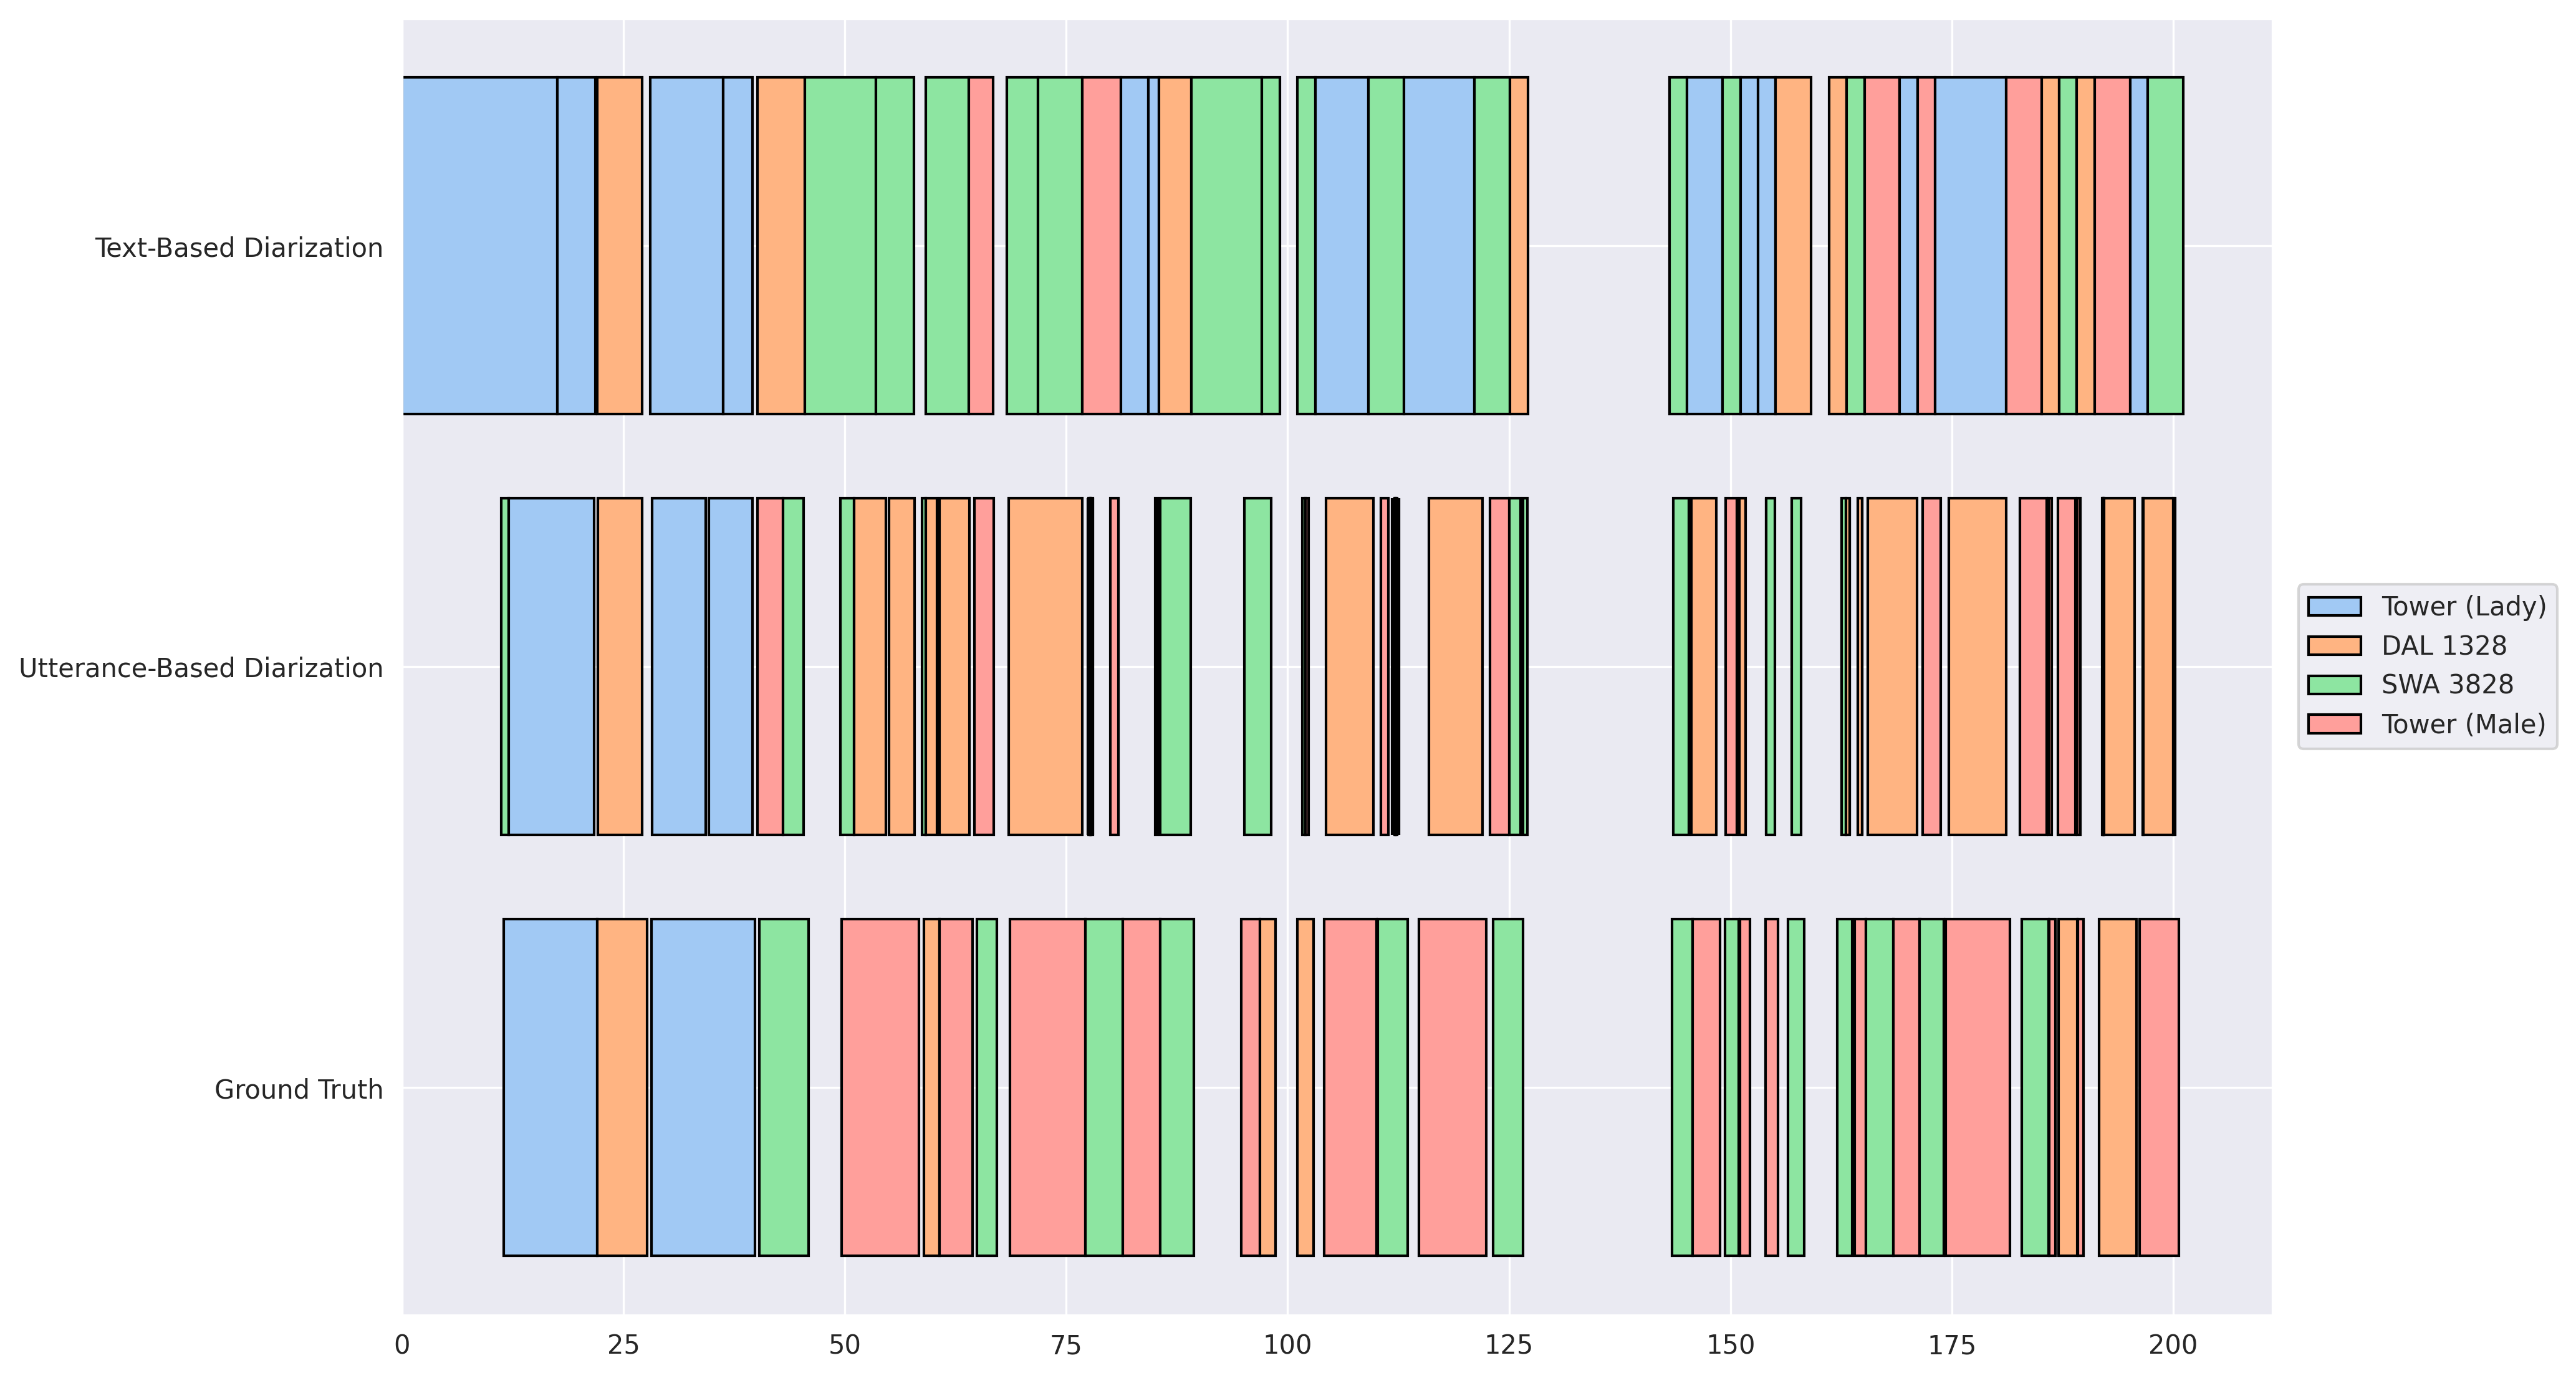

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume merged_df, utterance_df, and ground_truth_df are already defined

# Define Seaborn color palette for speakers
sns_colors = sns.color_palette("pastel", 4)
colors = {
    "Speaker 1": sns_colors[0],
    "Speaker 2": sns_colors[1],
    "Speaker 3": sns_colors[2],
    "Speaker 4": sns_colors[3]
}

# Custom legend labels
custom_labels = {
    "Speaker 1": "Tower (Lady)",
    "Speaker 2": "DAL 1328",
    "Speaker 3": "SWA 3828",
    "Speaker 4": "Tower (Male)"
}

def plot_speaker_intervals(ax, df, position, colors):
    for _, row in df.iterrows():
        ax.barh(position, row['end'] - row['start'], left=row['start'], color=colors[row['speaker']], edgecolor='black', label=row['speaker'])

fig, ax = plt.subplots(figsize=(16, 9), dpi=300)  # Increased resolution

plot_speaker_intervals(ax, merged_df, 3, colors)
plot_speaker_intervals(ax, utterance_df, 2, colors)
plot_speaker_intervals(ax, ground_truth_df, 1, colors)

# Set y-ticks and y-tick labels
ax.set_yticks([2, 3, 1])
ax.set_yticklabels(["Utterance-Based Diarization", "Text-Based Diarization", "Ground Truth"])

# Create custom legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Map the default labels to custom labels
custom_handles = [by_label["Speaker 1"], by_label["Speaker 2"], by_label["Speaker 3"], by_label["Speaker 4"]]
custom_labels = [custom_labels["Speaker 1"], custom_labels["Speaker 2"], custom_labels["Speaker 3"], custom_labels["Speaker 4"]]

# Add space for the legend on the right
plt.subplots_adjust(right=0.75)
ax.legend(custom_handles, custom_labels, loc='center left', bbox_to_anchor=(1.007, 0.5))

plt.show()


In [21]:
from rich.console import Console
from rich.table import Table
from rich.text import Text
from rich.box import SIMPLE
from html2image import Html2Image

# Function to apply color to differences
def highlight_diff(text1, text2, diffs):
    for diff_word1, diff_word2 in diffs:
        if diff_word1:
            text1 = text1.replace(diff_word1, f"[red]{diff_word1}[/red]")
        if diff_word2:
            text2 = text2.replace(diff_word2, f"[green]{diff_word2}[/green]")
    return text1, text2

# Sample diffs structure
diffs = [
    [
        ["To clear to cross 31 Center and 31 left...",
         "We're clear to cross 31 Center and 31 left..."],
        [["To clear to cross", "We're clear to cross"]]
    ],
    [
        ["... switch over to power, have a good day.",
         "... switch over to tower, have a good day."],
        [["power", "tower"]]
    ],
    [
        ["... approach 31 right, Delta 320.",
         "... approach 31 right, Southwest 3828."],
        [["Delta 320", "Southwest 3828"]]
    ],
    [
        ["... 0 mile final, 4 right, line up right.",
         "... 0 mile final, 4 right, line up and wait."],
        [["line up right", "line up and wait"]]
    ],
    [
        ["... runway 31 Center, line up right, jump line up top.",
         "... runway 31 Center, line up and wait, jump line up top."],
        [["line up right", "line up and wait"]]
    ],
    [
        ["Delta 1328, line up right, Southwest 3828.",
         "31 Center, line up and wait, Southwest 3828."],
        [["Delta 1328, line up right", "31 Center, line up and wait"]]
    ],
    [
        ["Alright traffic hold position ... traffic on A3 mile final, cross runway,",
         "Southwest 3828 traffic hold position ... traffic on a 3 mile final, cross runway,"],
        [["Alright traffic hold position", "Southwest 3828 traffic hold position"], ["A3 mile final", "a 3 mile final"]]
    ],
    [
        ["notify Nodal 8 please, turn left heading 250...",
         "no delay please, turn left heading 250..."],
        [["notify Nodal 8", "no delay"]]
    ],
    [
        ["Left heading 250, Southwest 3828, clear for takeoff, Niner.",
         "completely inaudible"],
        [["Left heading 250, Southwest 3828, clear for takeoff, Niner.", "completely inaudible"]]
    ],
    [
        ["...verify Nodal 8 left heading 250,",
         "...verify no delay left heading 250,"],
        [["Nodal 8", "no delay"]]
    ],
    [
        ["through and center, clear for takeoff.",
         "31 Center, clear for takeoff."],
        [["through and center", "31 Center"]]
    ],
    [
        ["Northwest 3828, Nodal 8 heading 250, Southwest 3828.",
         "Cleared for takeoff, 31 Center no delay, heading 250, Southwest 3828."],
        [["Northwest 3828, Nodal 8 heading 250, Southwest 3828.", "Cleared for takeoff, 31 Center no delay, heading 250, Southwest 3828."]]
    ],
    [
        ["Southwest 3828, stop, stop, stop.",
         "Delta 1328, stop, stop, stop."],
        [["Southwest 3828", "Delta 1328"]]
    ],
    [
        ["We're stopping.",
         "Delta 1328 stopping."],
        [["We're stopping.", "Delta 1328 stopping"]]
    ],
    [
        ["Alright make the right turn onto taxiway Delta, ...",
         "Make the right turn onto taxiway Delta, ..."],
        [["Alright make the right turn", "Make the right turn"]]
    ],
    [
        ["In over.",
         "..."],
        [["In over.", "..."]]
    ],
    [
        ["AFIRM sir, is it gonna be...",
         "affirm sir, is it gonna be..."],
        [["AFIRM", "affirm"]]
    ],
    [
        ["13828.",
         "Southwest 3828"],
        [["13828.", "Southwest 3828"]]
    ],
    [
        ["13828.",
         "Southwest 3828?"],
        [["13828.", "Southwest 3828?"]]
    ],
    [
        ["Good, good, good, sir.",
         "Go ahead sir?"],
        [["Good, good, good, sir.", "Go ahead sir?"]]
    ],
    [
        ["Roger.",
         "Roger."],
        [["Roger.", "Roger"]]
    ],
    [
        ["... you can sit there for as long as you may.",
         "... you can sit there for as long as you need."],
        [["as long as you may.", "as long as you need."]]
    ]
]

# Prepare console for rich rendering
console = Console(record=True, width=200)

# Print the differences side-by-side with formatting
table = Table(show_header=True)
table.add_column("Whisper Transcription", justify="right")
table.add_column("Ground Truth", justify="left")

for diff in diffs:
    text1, text2 = diff[0]
    diffs_list = diff[1]
    highlighted1, highlighted2 = highlight_diff(text1, text2, diffs_list)
    table.add_row(Text.from_markup(highlighted1), Text.from_markup(highlighted2))

console.print(table)

# Capture the output
html_output = console.export_html()
html_output = html_output.replace('<style>', '<style> body { font-family: "Courier New", Courier, monospace; } ')

# Save the HTML to a file
with open("./visualisations/transcription_comparison.html", "w") as f:
    f.write(html_output)



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                     Whisper Transcription ┃ Ground Truth                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                                To clear to cross 31 Center and 31 left... │ We're clear to cross 31 Center and 31 left...                                     │
│                                ... switch over to power, have a good day. │ ... switch over to tower, have a good day.                                        │
│                                         ... approach 31 right, Delta 320. │ ... approach 31 right, Southwest 3828.                                            │
│                                 ... 0 mile final, 4 right, line up right. │ ... 0 mile final, 4 right, line up and wait.                                      │
│                    ... runway 31 Center, line up right, jump line up top. │ ... runway 31 Center, line up and wait, jump line up top.                         │
│                                Delta 1328, line up right, Southwest 3828. │ 31 Center, line up and wait, Southwest 3828.                                      │
│ Alright traffic hold position ... traffic on A3 mile final, cross runway, │ Southwest 3828 traffic hold position ... traffic on a 3 mile final, cross runway, │
│                           notify Nodal 8 please, turn left heading 250... │ no delay please, turn left heading 250...                                         │
│               Left heading 250, Southwest 3828, clear for takeoff, Niner. │ completely inaudible                                                              │
│                                       ...verify Nodal 8 left heading 250, │ ...verify no delay left heading 250,                                              │
│                                    through and center, clear for takeoff. │ 31 Center, clear for takeoff.                                                     │
│                      Northwest 3828, Nodal 8 heading 250, Southwest 3828. │ Cleared for takeoff, 31 Center no delay, heading 250, Southwest 3828.             │
│                                         Southwest 3828, stop, stop, stop. │ Delta 1328, stop, stop, stop.                                                     │
│                                                           We're stopping. │ Delta 1328 stopping.                                                              │
│                       Alright make the right turn onto taxiway Delta, ... │ Make the right turn onto taxiway Delta, ...                                       │
│                                                                  In over. │ ...                                                                               │
│                                              AFIRM sir, is it gonna be... │ affirm sir, is it gonna be...                                                     │
│                                                                    13828. │ Southwest 3828                                                                    │
│                                                                    13828. │ Southwest 3828?                                                                   │
│                                                    Good, good, good, sir. │ Go ahead sir?                                                                     │
│                                                                    Roger. │ Roger.                                                                            │
│                             ... you can sit there for as long as you may. │ ... you can sit there for as long 

# Preparing for Air Incident Investigation
## Combining Transcription with Speaker Labels

Do note that we will be using Ground Truth data to get as accurate of an investigation as possible. 

The Whisper Model used for transcription and Pyannote Model used for diarization are used to analyse the capabilities of automated transcription and diarization.



In [18]:
speaker_ground_df = ground_truth_df.copy()
# Custom labels
custom_labels = {
    "Speaker 1": "Tower (Lady)",
    "Speaker 2": "DAL 1328",
    "Speaker 3": "SWA 3828",
    "Speaker 4": "Tower (Male)"
}

# Replace values
speaker_ground_df['speaker'] = speaker_ground_df['speaker'].replace(custom_labels)
speaker_ground_df

,start,end,speaker
0,11.52,22.07,Tower (Lady)
1,22.08,27.69,DAL 1328
2,28.17,39.87,Tower (Lady)
3,40.37,45.90,SWA 3828
4,49.67,58.34,Tower (Male)
5,58.92,60.67,DAL 1328
6,60.68,64.44,Tower (Male)
7,64.94,67.15,SWA 3828
8,68.63,77.18,Tower (Male)
9,77.19,81.38,SWA 3828


In [ ]:
diarization = client.chat.completions.create(
            model=DEPLOYMENT,
            messages=[
                {"role": "system", "content": "You are an expert at performing transcription-speaker cleanup. You will be provided with a table which contains the following: 1. Start timing of speech 2. End timing of speech 3. Speaker label. You will then be provided a list of sentences which are seperated inconsistently. Your task is to join the sentences and split them appropriately, to ensure that the X number of sentences are joined/split to fit into the Y rows of the speech table. These will be ATC-Pilot(s) conversations, and the ATC will START their messages addressing the Pilot's callsign, and the Pilot will END the speech with their own callsign. "},
                {"role": "user", "content": user_message}
            ],
            max_tokens=5000,
            stream=False,
            temperature=0.2,
        )